In [1]:
#Base
from glob import glob
import sys, os
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
from tqdm.notebook import trange, tqdm

#Plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.gridspec as gridspec

#V1DD
from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis import StimulusAnalysis
from allen_v1dd.stimulus_analysis.correlation import calculate_correlation, ProgressBar
from allen_v1dd.stimulus_analysis.natural_scenes import NaturalScenes
from allen_v1dd.stimulus_analysis.drifting_gratings import DriftingGratings

# EM-coregistration Github
# https://github.com/RussTorres/em_coregistration/tree/rmt_working_branch
sys.path.append('/home/david.wyrick/Git/em_coregistration/')
import coregister
import coregister.transform
import coregister.data_loader
from coregister.process.affine_matrices import transform_pts
from coregister.process.roi import center_from_pix_mask
from coregister.io.read_nwb import ROI_mask_nwb

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/plots'

In [2]:
# matrix that describes the transformation from the input functional space (in pixels) to the coregistration space (in microns) and its inverse
func_raw2coreg_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/func_raw2coreg_tform.npy"
func_raw2coreg_tform = np.load(func_raw2coreg_tform_fn)
func_coreg2raw_tform = np.linalg.inv(func_raw2coreg_tform)

# matrix that describes the transformation from the input EM coregistration space (in microns) to the final EM space (in voxels)
em_coreg2final_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/em_coreg2final_tform.npy"
em_coreg2final_tform = np.load(em_coreg2final_tform_fn)
em_final2coreg_tform = np.linalg.inv(em_coreg2final_tform)

In [3]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
ophys_client = OPhysClient(base_folder)

In [4]:
#Get depths for each volume/plane

depth_dict = {}
depth_list = []
col = 1
for vol in range(1,10):
    ophys_session_id = f'M409828_1{vol}'
    session = ophys_client.load_ophys_session(session_id=ophys_session_id)

    if vol <= 5:
        planemax = 7
    else:
        planemax = 2
    for plane in range(1,planemax):
        depth = session.get_plane_depth(plane)
        depth_list.append((1,vol,plane,depth))
        depth_dict[(col,vol,plane)] = depth
depths_df = pd.DataFrame(np.array(depth_list),columns=['column','volume','plane','depth'])


In [5]:
##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = ophys_client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [6]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import sobel

def return_cell_outlines(binary_image):
       img = np.array(binary_image,dtype=int)
       # define Sobel filter kernels for edge detection in x and y directions
       sobel_x_kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])

       sobel_y_kernel = np.array([[-1, -2, -1],
                            [0, 0, 0],
                            [1, 2, 1]])

       # apply Sobel filter to detect edges in x and y directions
       sobel_x = convolve2d(img, sobel_x_kernel, mode='same', boundary='symm')
       sobel_y = convolve2d(img, sobel_y_kernel, mode='same', boundary='symm')

       # combine Sobel x and y filters to get edge magnitude
       edge_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

       # threshold the edge detection output
       threshold = 1
       edge_mag[edge_mag < threshold] = 0
       edge_mag[edge_mag >= threshold] = 1
       edges = np.abs(edge_mag - 1)

       #find cell outlines
       tmp = img - edges
       edge_mask = tmp > 0
       cell_outlines = np.zeros(edge_mask.shape)*np.nan
       cell_outlines[edge_mask] = 1

       return cell_outlines


"Pt-d0-0","false","0","0","0","144.66078611111112","416.4888962962963","267.0"
"Pt-d0-1","false","0","0","0","146.0291025089606","417.47525304659496","283.0"
"Pt-d0-2","false","0","0","0","147.14542445652174","418.97565054347825","299.0"
"Pt-d0-3","false","0","0","0","144.81805758754865","417.9455182879377","315.0"
"Pt-d0-4","false","0","0","0","143.81528571428572","418.13476095238093","331.0"
"Pt-d0-5","false","0","0","0","145.13119587628864","416.8374680412371","347.0"


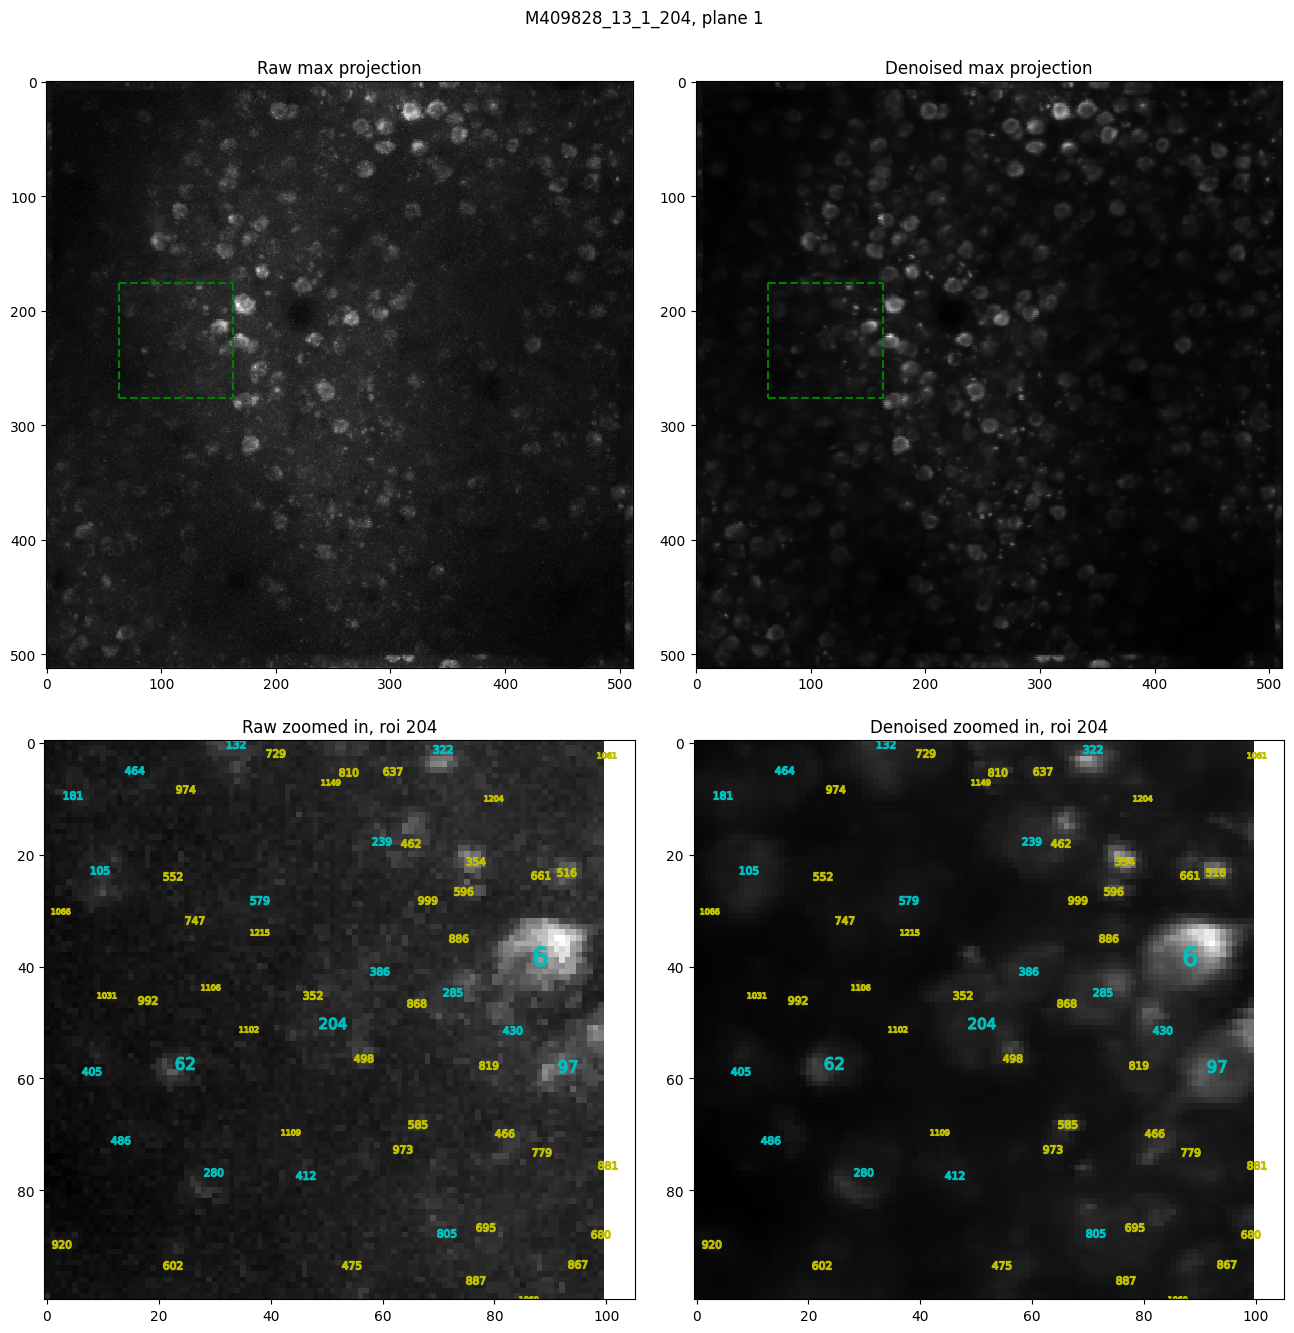

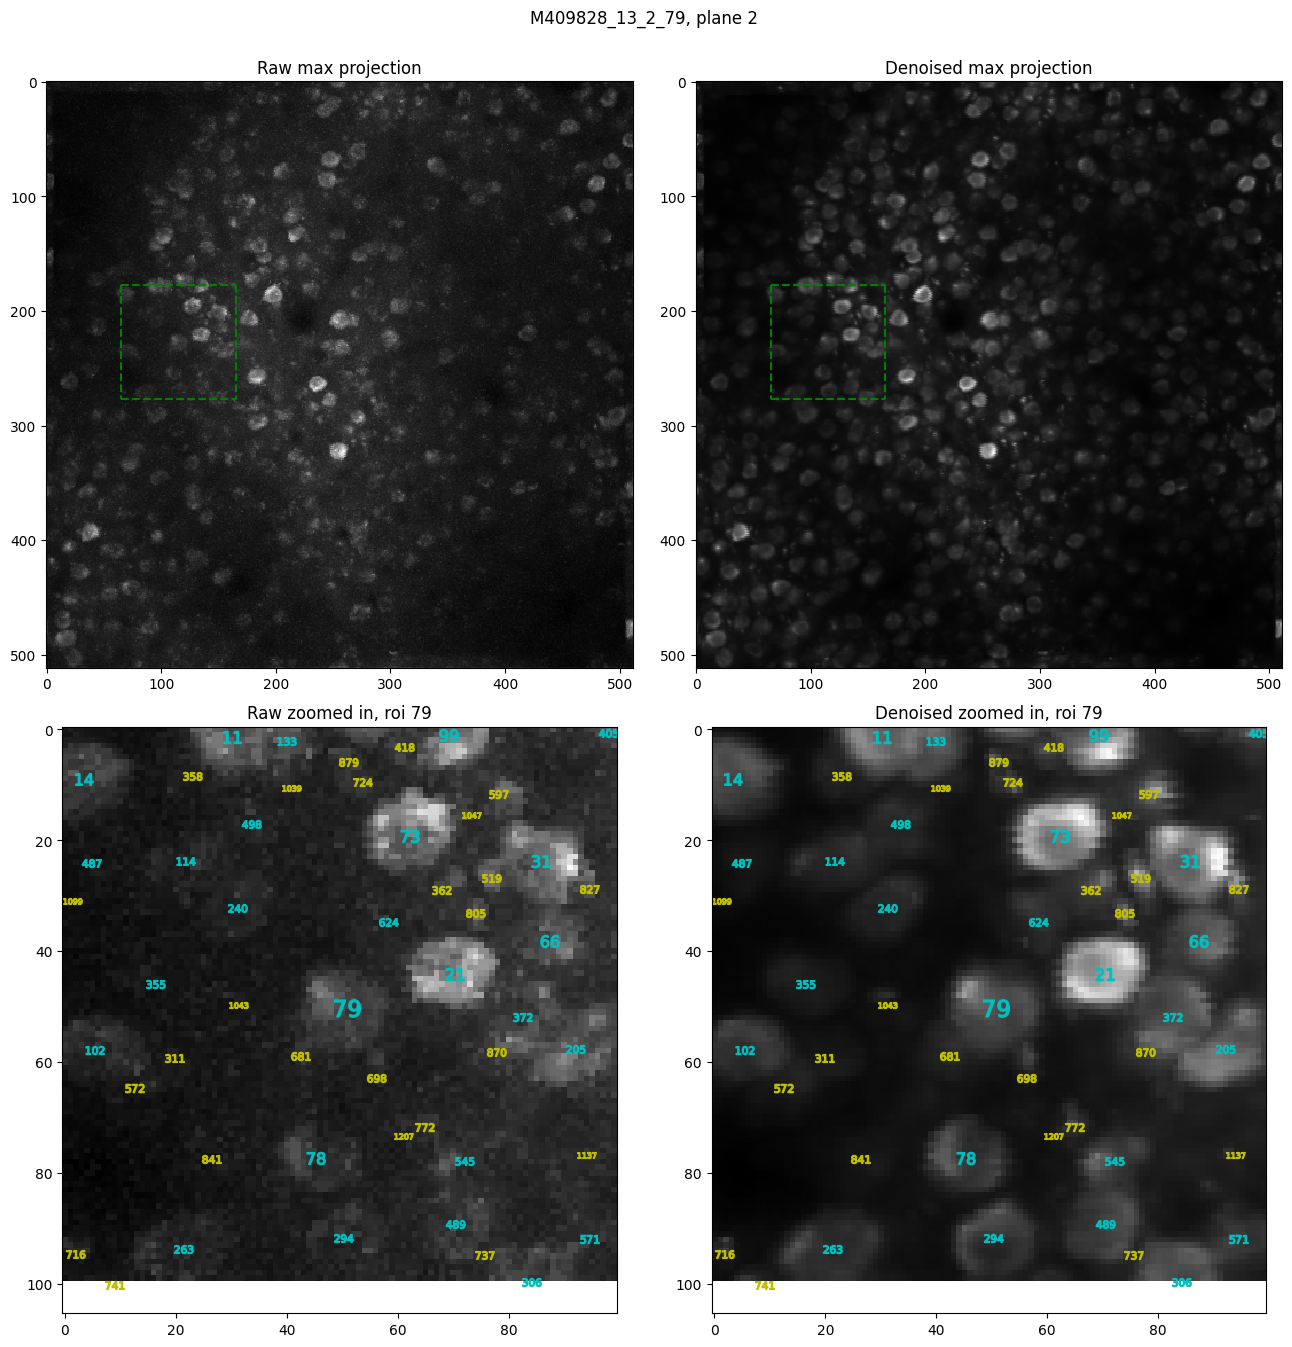

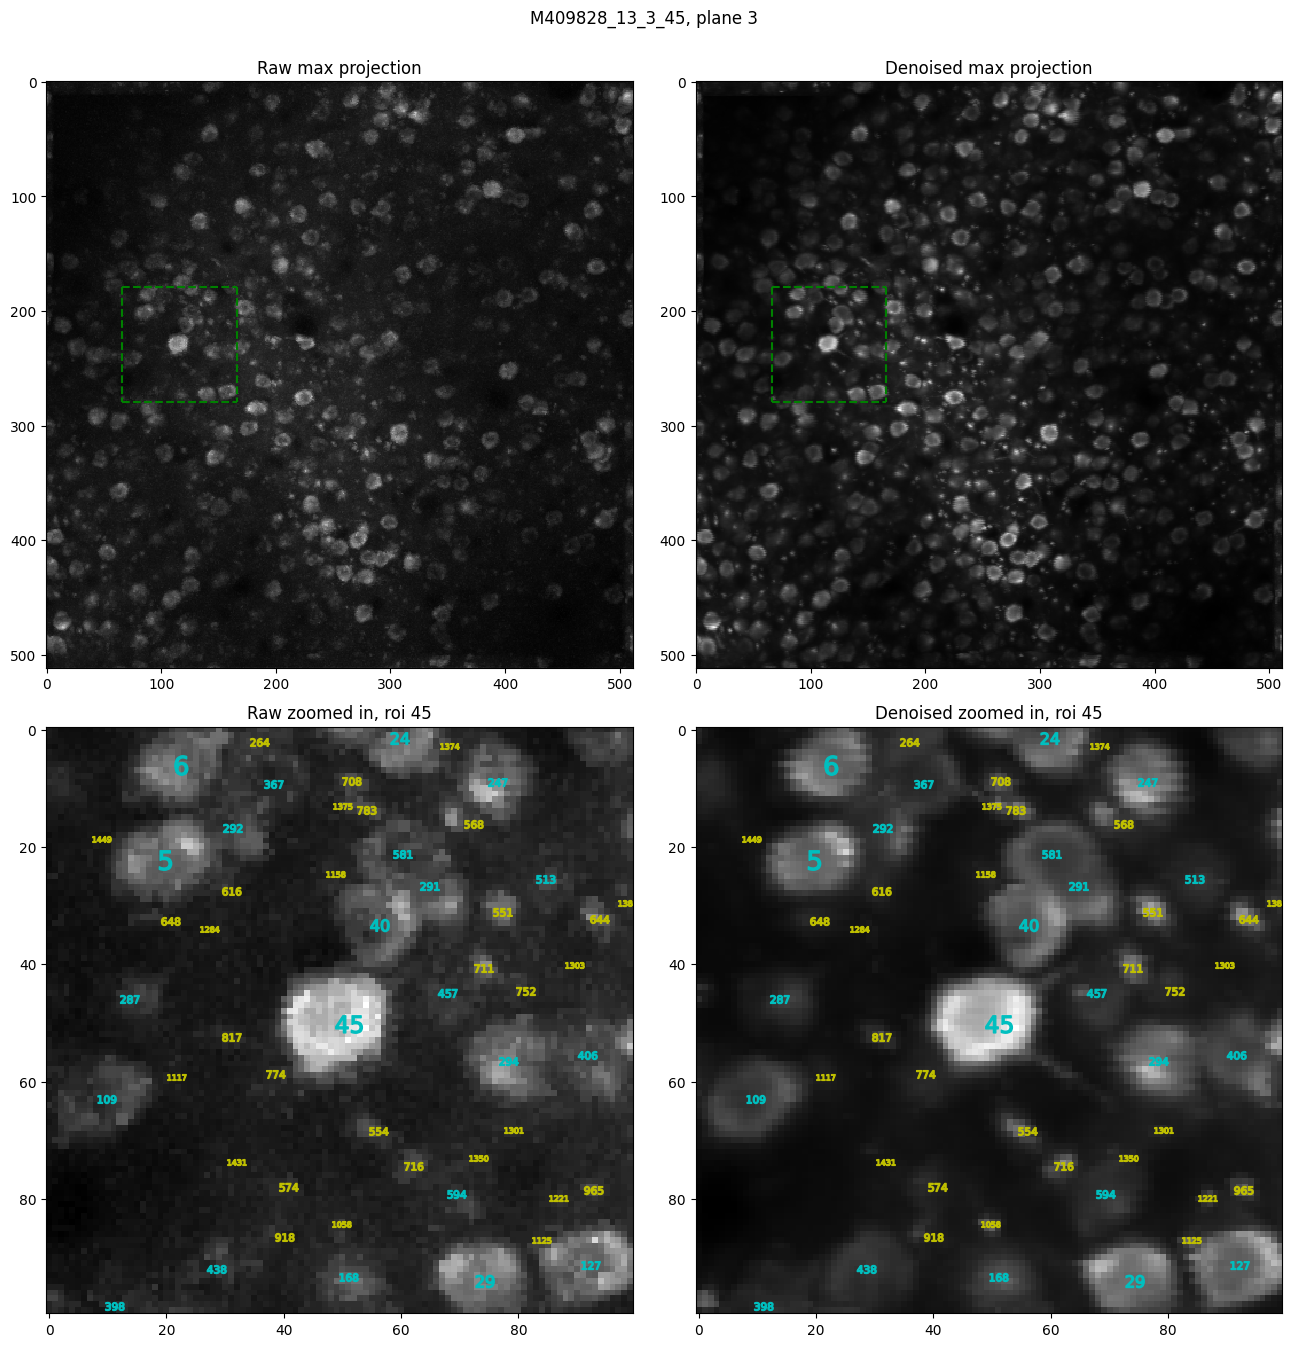

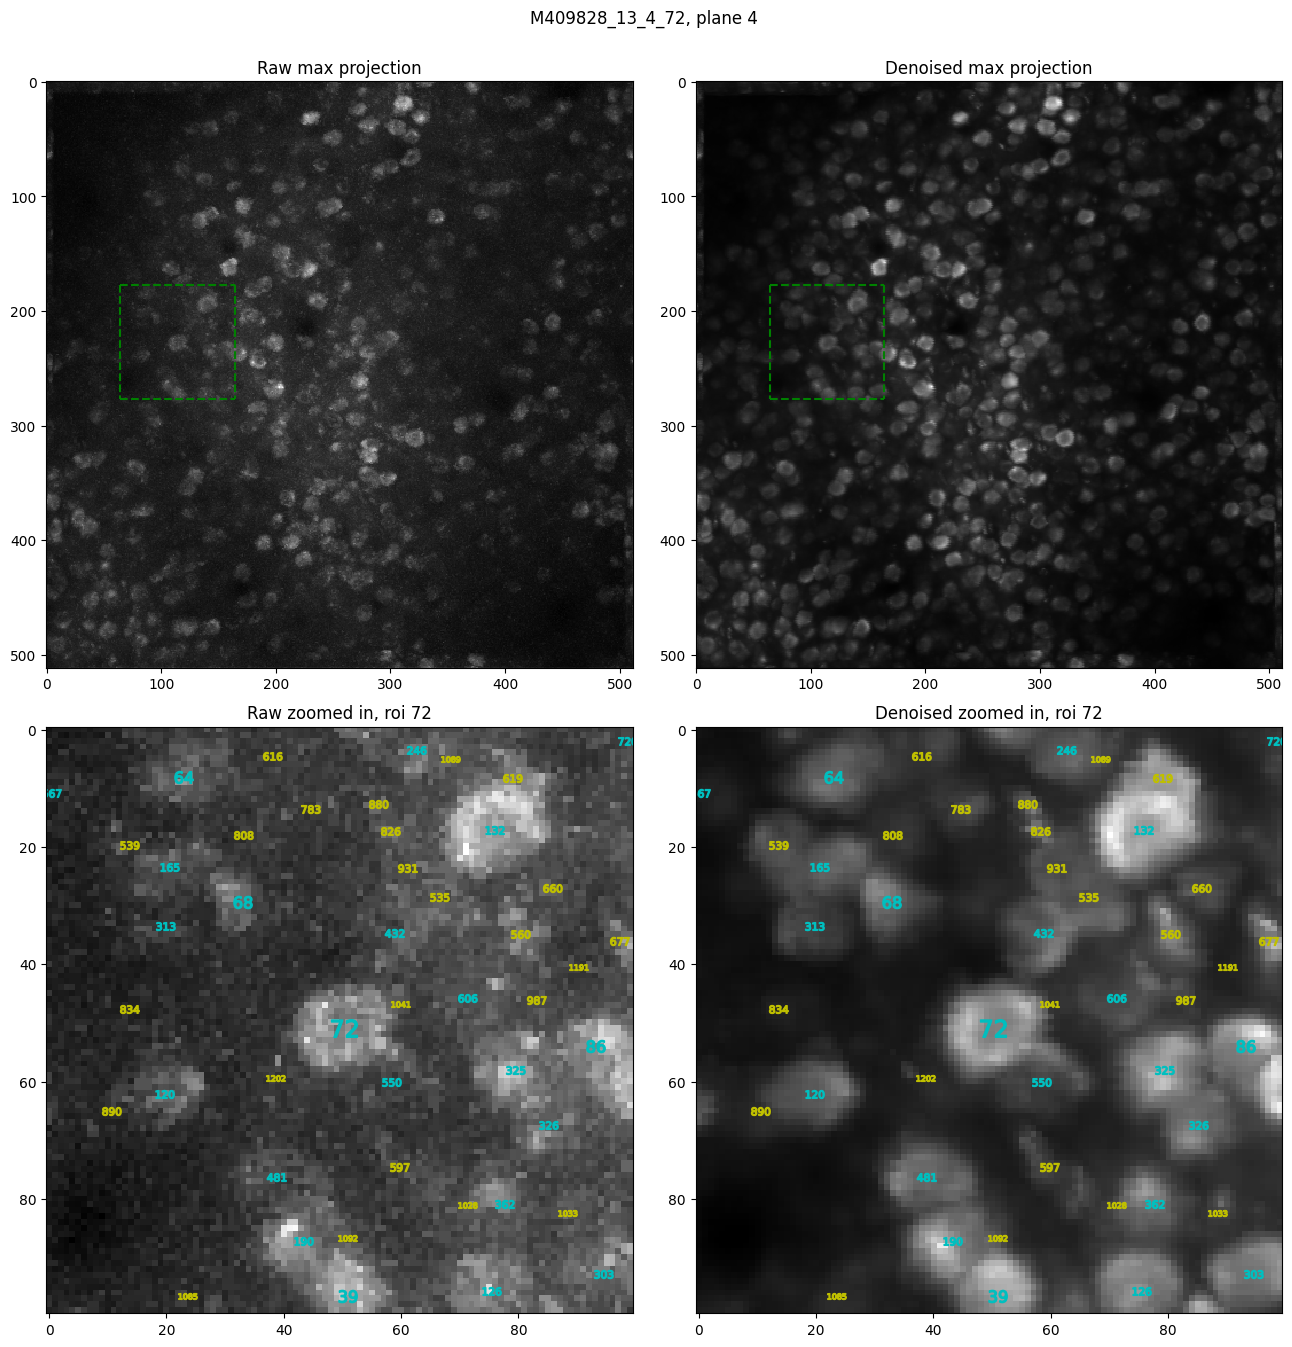

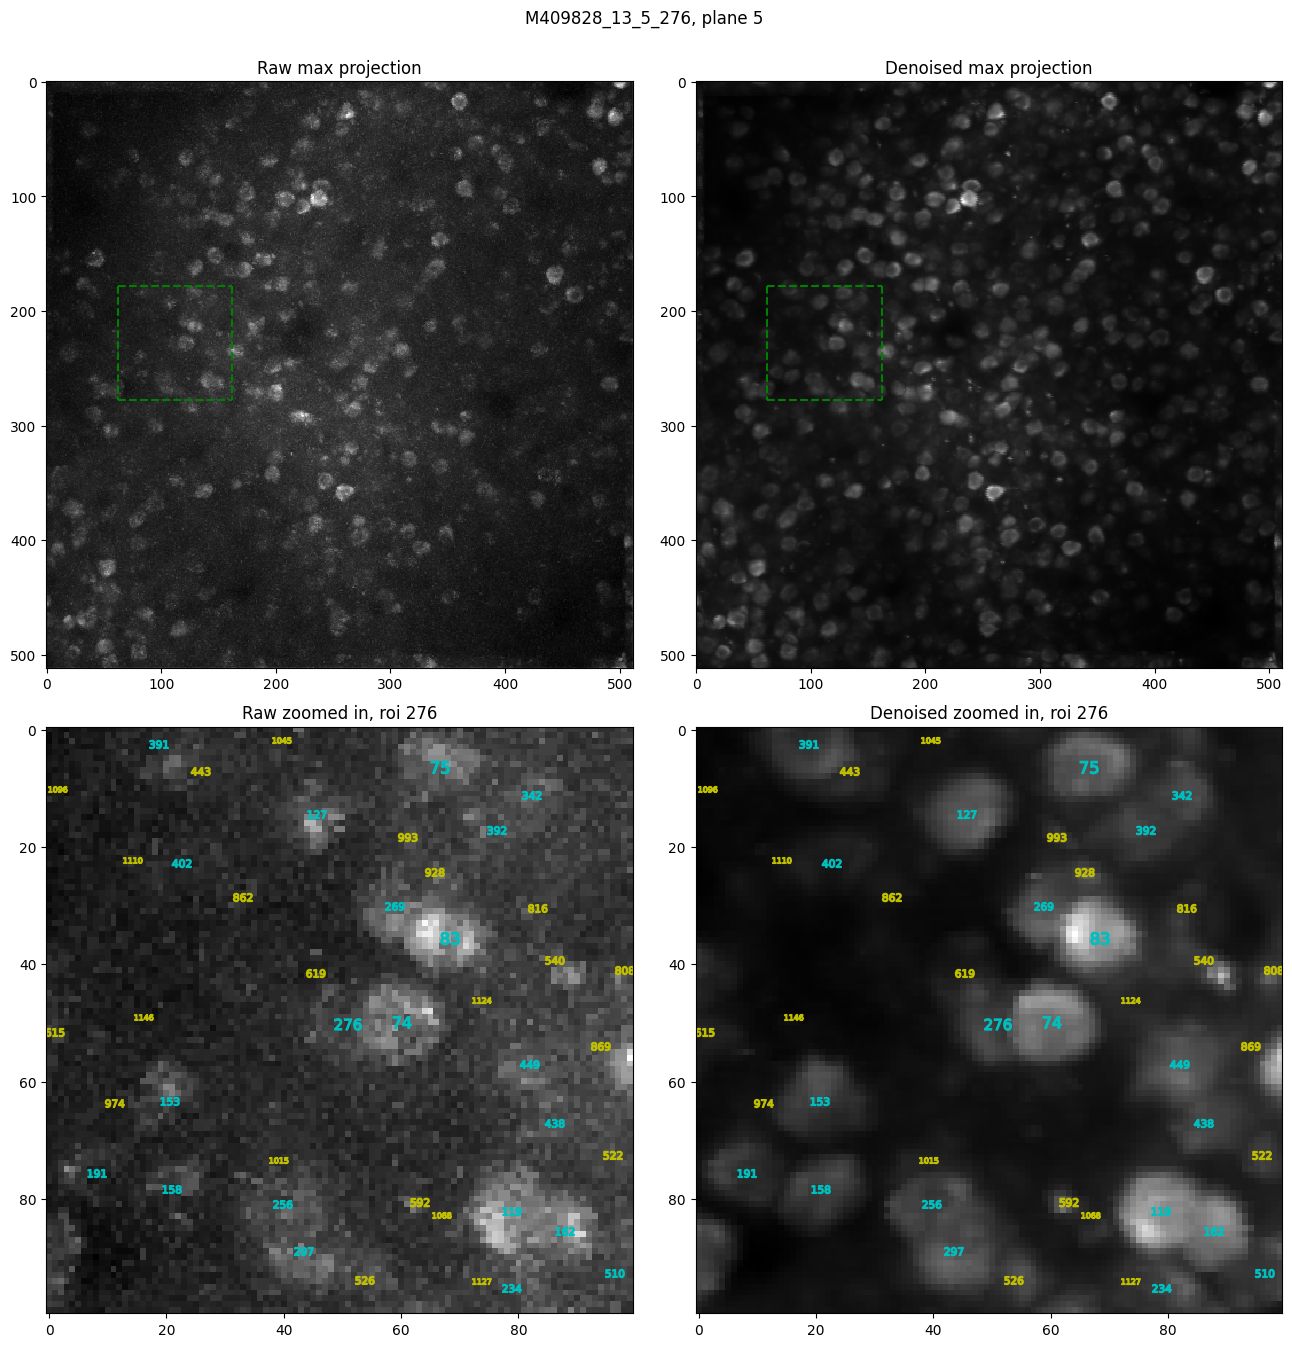

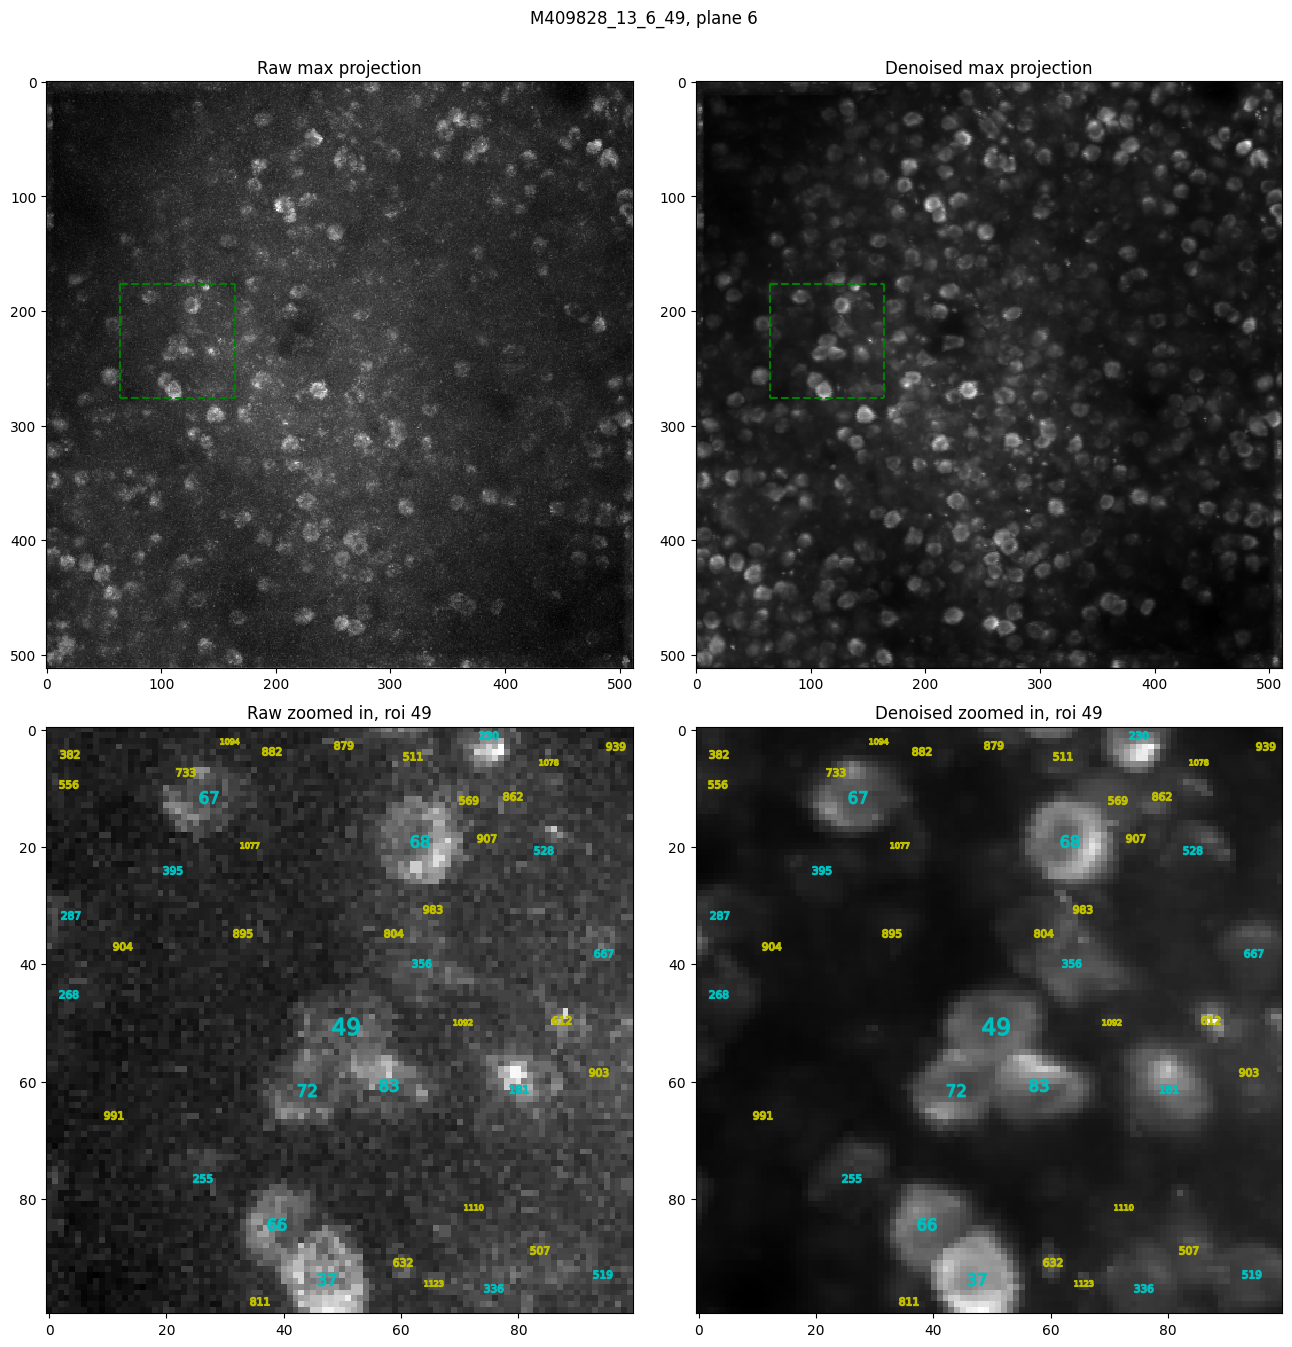

In [56]:
duplicates_list = [["M409828_13_1_129", "M409828_13_2_68", "M409828_13_3_10", "M409828_13_4_81", "M409828_13_5_192", "M409828_13_6_179"],
["M409828_13_1_350", "M409828_13_2_131", "M409828_13_3_94", "M409828_13_4_219", "M409828_13_5_367", "M409828_13_6_103"],
["M409828_13_1_52", "M409828_13_2_6", "M409828_13_3_3", "M409828_13_4_12", "M409828_13_5_52", "M409828_13_6_1"],
["M409828_13_1_126", "M409828_13_2_63", "M409828_13_3_27", "M409828_13_4_66", "M409828_13_5_328", "M409828_13_6_112"],
["M409828_13_1_204", "M409828_13_2_79", "M409828_13_3_45", "M409828_13_4_72", "M409828_13_5_276", "M409828_13_6_49"],
["M409828_13_1_225", "M409828_13_2_274", "M409828_13_3_115", "M409828_13_4_181", "M409828_13_5_242", "M409828_13_6_306"]]

for jj, dupli in enumerate(duplicates_list[4:5]):
    
    tmp = np.zeros((6,3)); depths = np.zeros((6,1))
    for ii, d in enumerate(dupli):
        text = d.split('_')
        col = int(text[1][0])
        vol = int(text[1][1])
        plane = int(text[2])
        roi_center = int(text[3])
        xypixels = sess.get_roi_xy_pixels(plane,roi_center)

        mask = sess.get_roi_image_mask(plane,roi_center)
        proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

        yc = np.mean(xypixels[0])
        xc = np.mean(xypixels[1])
        # y, x = np.mean(np.where(sess.get_roi_image_mask(plane=plane, roi=roi_center)), axis=1) # note this is transposed

        area = np.sum(mask)
        # import pdb; pdb.set_trace()
        fig, axes = plt.subplots(2,2,figsize=(16,16),gridspec_kw={'wspace':0.1,'hspace':0.1})
        plt.suptitle(f'{d}, plane {plane}',y=0.925)

        ax = axes[0,0]
        ax.set_title(f'Raw max projection')
        buff = 50
        vmin = proj_raw_max.min(); vmax = proj_raw_max.max()
        ax.imshow(proj_raw_max, cmap='gray', vmin=vmin,vmax=vmax,interpolation='nearest')
        
        # ax.plot(yc,xc,'xc')
        ax.vlines(int(yc)-buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')
        ax.vlines(int(yc)+buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')

        ax.hlines(int(xc)-buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')
        ax.hlines(int(xc)+buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')

        ax = axes[1,0]
        ax.set_title(f'Raw zoomed in, roi {roi_center}')
        ax.imshow(proj_raw_max[slice(int(xc)-buff,int(xc)+buff),slice(int(yc)-buff,int(yc)+buff)], cmap='gray', interpolation='nearest')

        ax = axes[0,1]
        ax.set_title(f'Denoised max projection')
        # vmin = proj_de_max.min(); vmax = proj_de_max.max() vmin=vmin,vmax=vmax,
        ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')

        # ax.plot(yc,xc,'xc')
        ax.vlines(int(yc)-buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')
        ax.vlines(int(yc)+buff,int(xc)-buff,int(xc)+buff,ls='--',color='g')

        ax.hlines(int(xc)-buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')
        ax.hlines(int(xc)+buff,int(yc)-buff,int(yc)+buff,ls='--',color='g')

        ax = axes[1,1]
        ax.set_title(f'Denoised zoomed in, roi {roi_center}')
        ax.imshow(proj_de_max[slice(int(xc)-buff,int(xc)+buff),slice(int(yc)-buff,int(yc)+buff)], cmap='gray', interpolation='nearest')
        # ax.plot(buff,buff,'Xg')
        

        rois = np.array(sess.get_rois(plane))
        # indy = sess.is_roi_valid(plane,rois)
        # mask = sess.get_roi_image_mask(plane,rois[indy])
        # xypixels = sess.get_roi_xy_pixels(plane,rois[~indy])

        xstart = int(xc)-50; ystart = int(yc)-50
        
        for roi in rois:
            is_valid = sess.is_roi_valid(plane,roi)
            xypixels = sess.get_roi_xy_pixels(plane,roi)
            color = 'c' if is_valid else 'y'
            if roi == roi_center:
                size = 20
            else:
                size = 14
            x = np.mean(xypixels[1])
            y = np.mean(xypixels[0])
            
            if (x > xc - 50) & (x < xc + 50) & (y > yc - 50) & (y < yc + 50):
                axes[1,0].plot(y-ystart,x-xstart,color=color,marker=f'${roi}$',markersize=size)
                axes[1,1].plot(y-ystart,x-xstart,color=color,marker=f'${roi}$',markersize=size)

        indy = sess.is_roi_valid(plane,roi_center); 
        mask = sess.get_roi_image_mask(plane,roi_center)
        cell_outlines = return_cell_outlines(mask)

        tmp[ii,:] = [yc,xc,plane-1]
        # plt.close(fig)
    
    #Transform points in raw pixel space to coregistration space
    points_func_coreg_pts = transform_pts(func_raw2coreg_tform,tmp)

    for ii, d in enumerate(points_func_coreg_pts):
        print(f'"Pt-d{jj}-{ii}","false","0","0","0","{d[0]}","{d[1]}","{d[2]}"')
    

blood_vessel_roi = ["M409828_13_1_222", "M409828_13_2_87", "M409828_13_3_567", "M409828_13_4_1260", "M409828_13_5_491", "M409828_13_6_31"]

In [7]:
#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
tStart = stim_table.at[0,'start']
tEnd = stim_table.at[0,'end']



Text(77.92222222222227, 0.5, 'Plane')

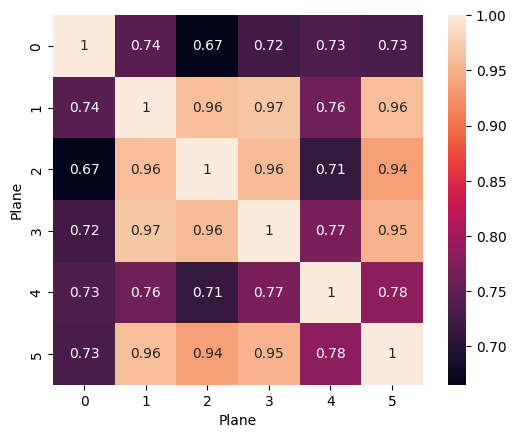

In [33]:
corr_mat = np.zeros((6,6))
for i, t1 in enumerate(trace_list):
    for j, t2 in enumerate(trace_list):
        s = np.min([t1.shape[0],t2.shape[0]])
        corr_mat[i,j] = np.corrcoef(t1[:s],t2[:s])[0,1]

sns.heatmap(corr_mat,square=True,annot=True)
plt.xlabel('Plane');plt.ylabel('Plane')

106.93856699879474
> /tmp/ipykernel_5726/3129719984.py(51)<module>()
     49 
     50 
---> 51         data_xr = sess.get_traces(ii+1,'dff')
     52         time = data_xr.coords['time'].values
     53         indy = np.where(time >= tStart & time <= tEnd)[0]



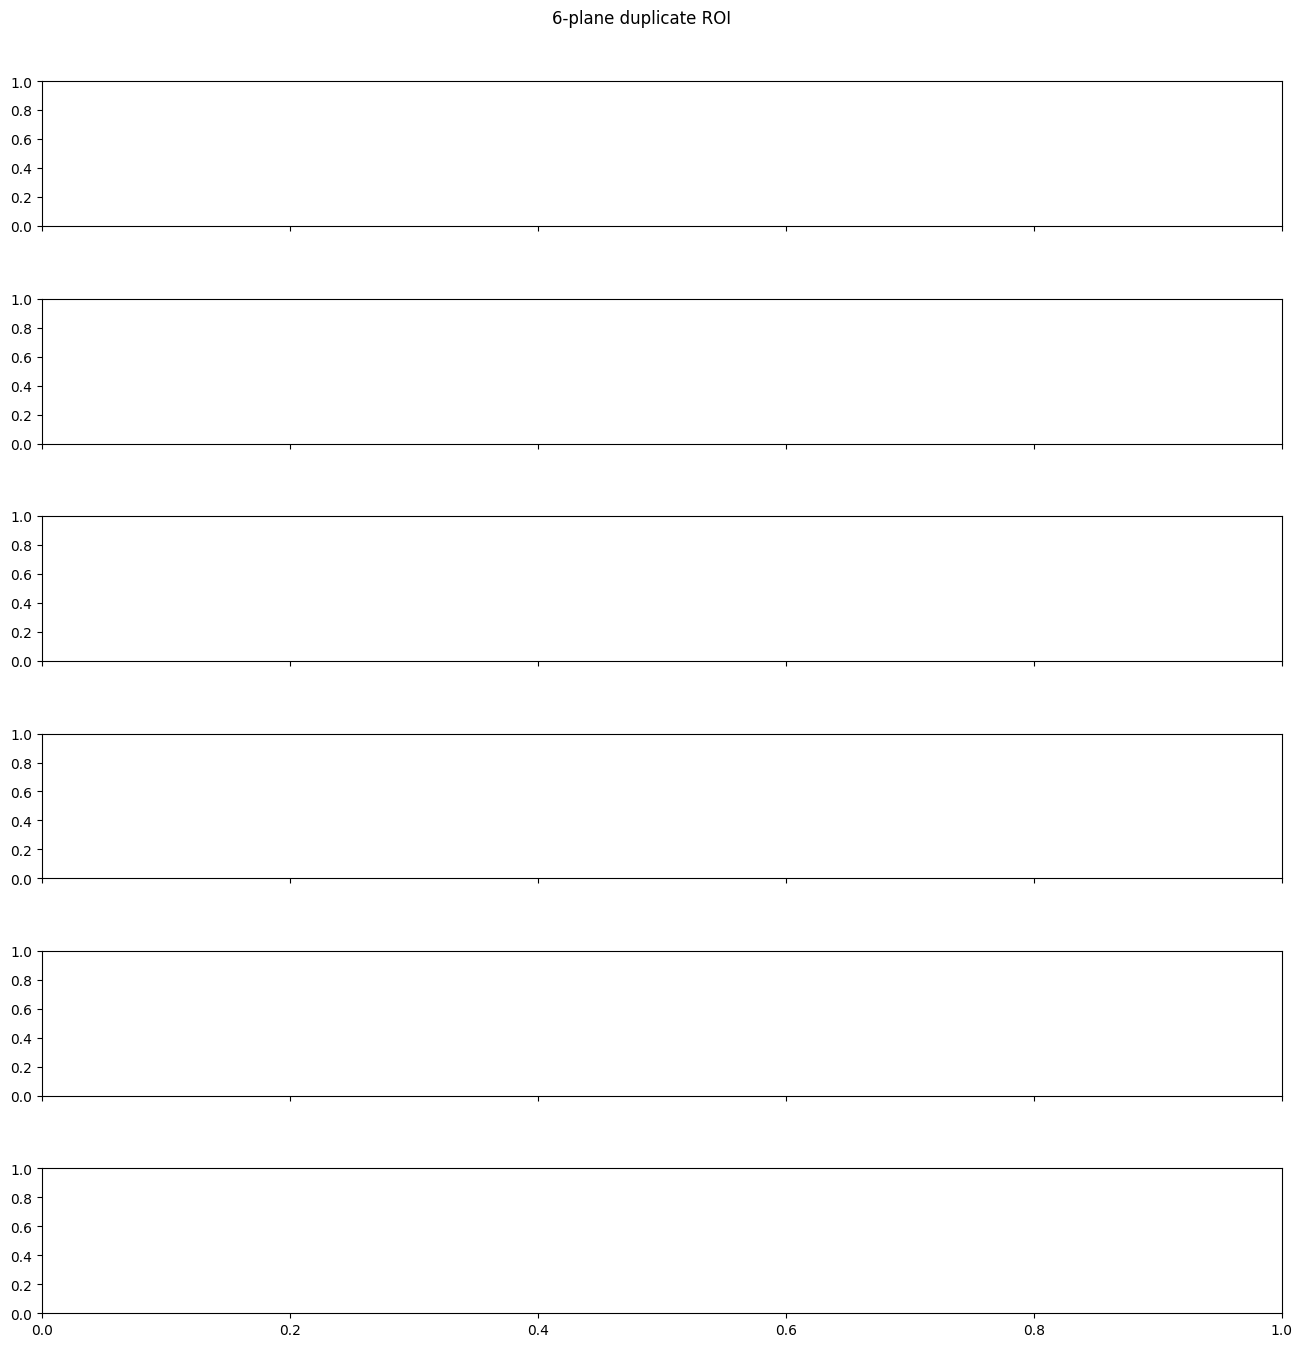

In [100]:
import h5py

BaseDir = '/data/v1dd_session13_raw_data/'

stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
tStart = stim_table.loc[0,'start']
tEnd = stim_table.loc[0,'end']

duplicates_list = [["M409828_13_1_129", "M409828_13_2_68", "M409828_13_3_10", "M409828_13_4_81", "M409828_13_5_192", "M409828_13_6_179"],
["M409828_13_1_350", "M409828_13_2_131", "M409828_13_3_94", "M409828_13_4_219", "M409828_13_5_367", "M409828_13_6_103"],
["M409828_13_1_52", "M409828_13_2_6", "M409828_13_3_3", "M409828_13_4_12", "M409828_13_5_52", "M409828_13_6_1"],
["M409828_13_1_126", "M409828_13_2_63", "M409828_13_3_27", "M409828_13_4_66", "M409828_13_5_328", "M409828_13_6_112"],
["M409828_13_1_204", "M409828_13_2_79", "M409828_13_3_45", "M409828_13_4_72", "M409828_13_5_276", "M409828_13_6_49"],
["M409828_13_1_225", "M409828_13_2_274", "M409828_13_3_115", "M409828_13_4_181", "M409828_13_5_242", "M409828_13_6_306"]]

for jj, dupli in enumerate(duplicates_list[:1]):
    
    from scipy.ndimage import gaussian_filter1d

    fig, axes = plt.subplots(6,1,figsize=(16,16),gridspec_kw={'hspace':0.5},sharey=False,sharex=True)
    plt.suptitle('6-plane duplicate ROI',y=0.925)

    tmp = np.zeros((6,3)); depths = np.zeros((6,1))
    for ii, d in enumerate(dupli):
        text = d.split('_')
        col = int(text[1][0])
        vol = int(text[1][1])
        plane = int(text[2])
        roi_center = int(text[3])
        xypixels = sess.get_roi_xy_pixels(plane,roi_center)

        mask = sess.get_roi_image_mask(plane,roi_center)
        proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

        yc = np.mean(xypixels[0])
        xc = np.mean(xypixels[1])
        xy = np.array([xc,yc])

        dist_list = []
        for stat in data[plane-1]['stat']:
            xy2 = np.array([np.mean(stat['ypix']),np.mean(stat['ypix'])])
 

            dist_list.append(np.linalg.norm(xy-xy2))
        print(np.min(dist_list))
        pdb.set_trace()

            

        
        data_xr = sess.get_traces(ii+1,'dff')
        time = data_xr.coords['time'].values
        indy = np.where(time >= tStart & time <= tEnd)[0]
        
        import pdb; pdb.set_trace()
        trace = sess.get_spont_traces(plane,'dff').sel(roi=roi)

        ax = axes[ii]
        ax.plot(gaussian_filter1d(trace,sigma=3),'-k')
        ax.set_ylabel('dfof')
        ax.set_title(f'Plane {plane}, roi {roi}, {np.sum(mask)} pixels,  Pika score: {pika_score:.2f}')

        ax2 = ax.twinx()
        ax2.plot(gaussian_filter1d(trace2,sigma=3),'-r')
        ax2.set_ylabel('raw')
        



462.3031817627545

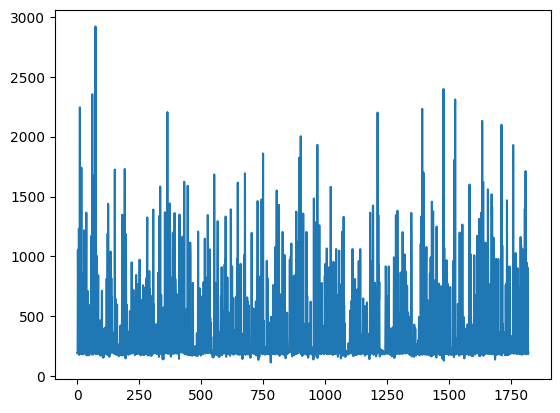

In [73]:
plt.plot(raw_images[indy,int(yc),int(xc)])

In [70]:
stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
tStart = stim_table.loc[0,'start']
tEnd = stim_table.loc[0,'end']

time = data_xr.coords['time'].values
indy = np.where((time >= tStart) & (time <= tEnd))[0]


1820

In [89]:
data[p]['Fneu'].shape

(240, 21612)

In [86]:
import h5py

BaseDir = '/data/v1dd_session13_raw_data/suite2p/'

data = {plane: {} for plane in range(6)}
for p in range(6):
    FileList = sorted(glob(os.path.join(BaseDir,f'plane{p}','*.npy')))
    for fpath in FileList:
        key = fpath.split('/')[-1][:-4]
        data[p][key] = np.load(fpath,allow_pickle=True)


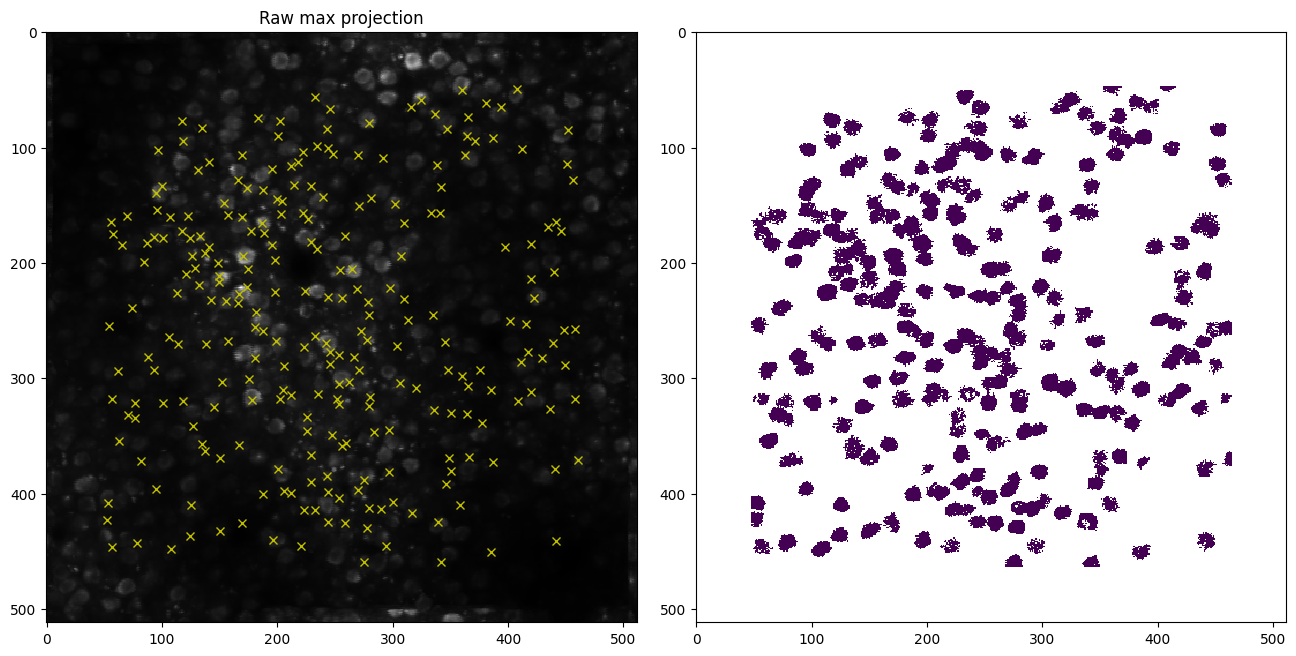

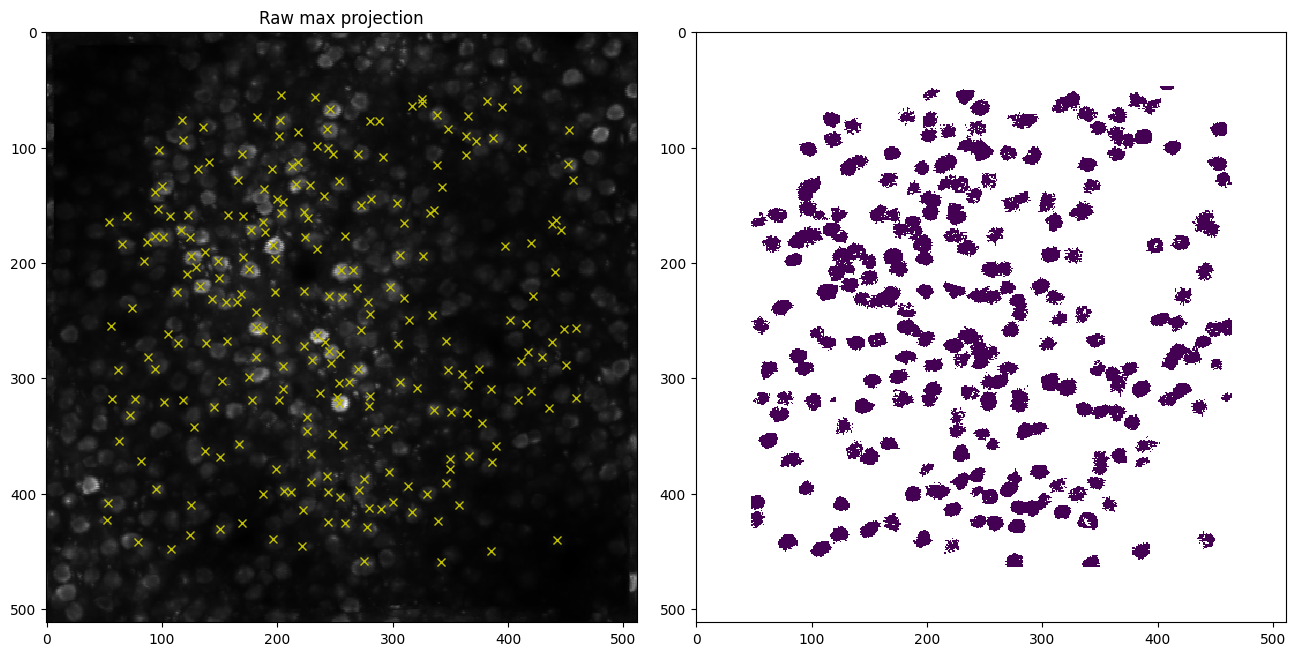

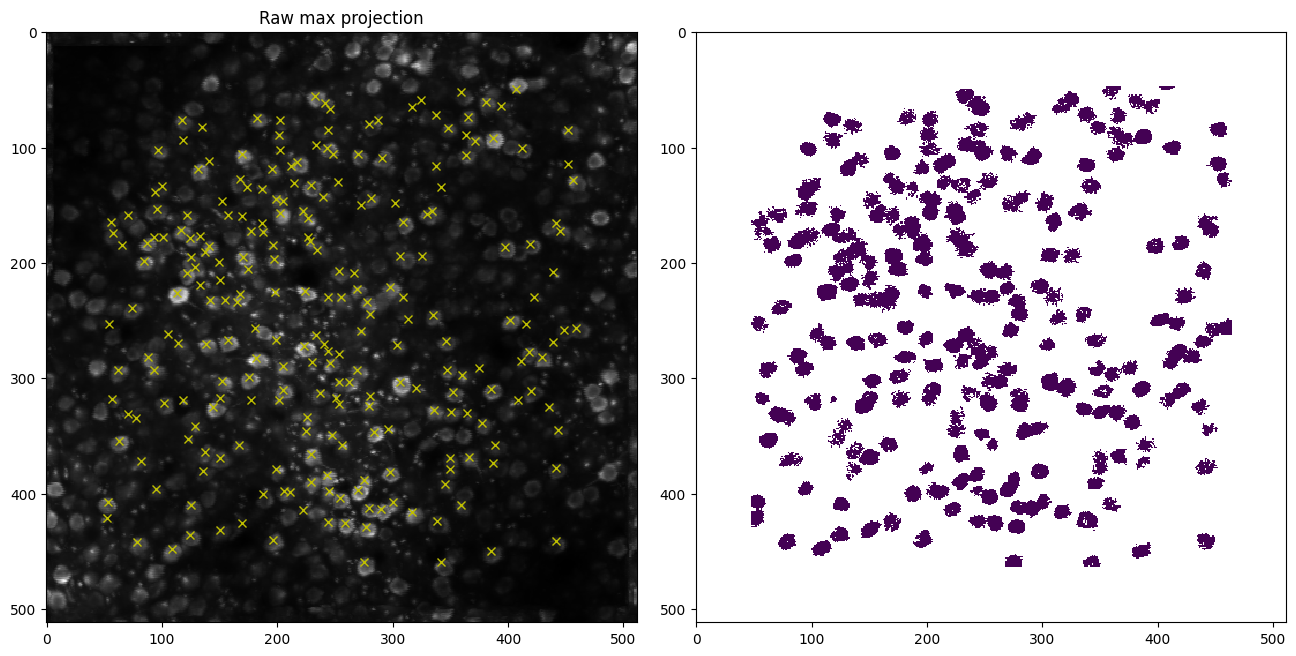

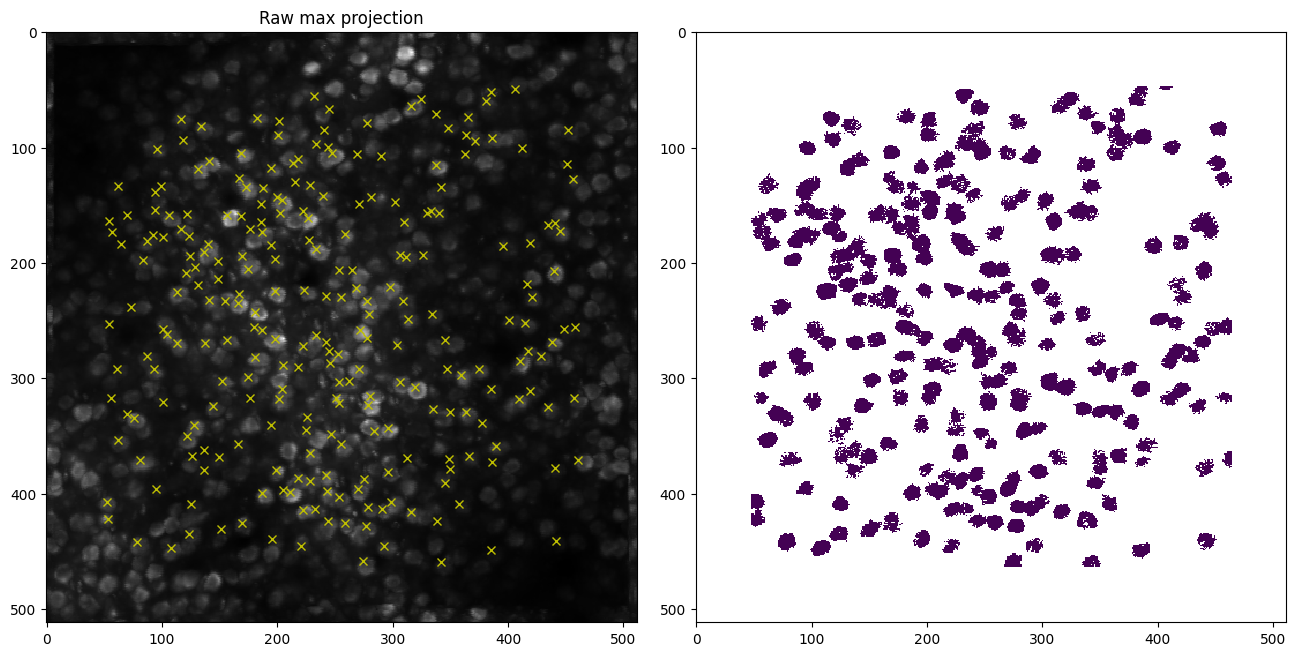

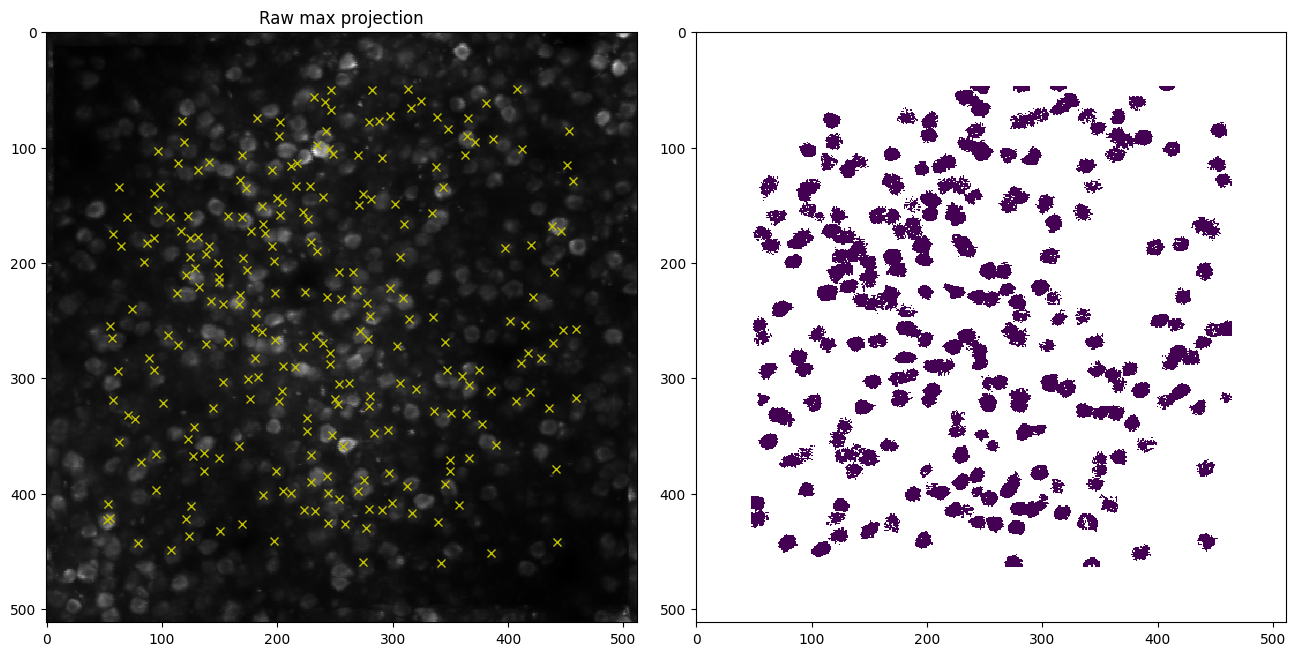

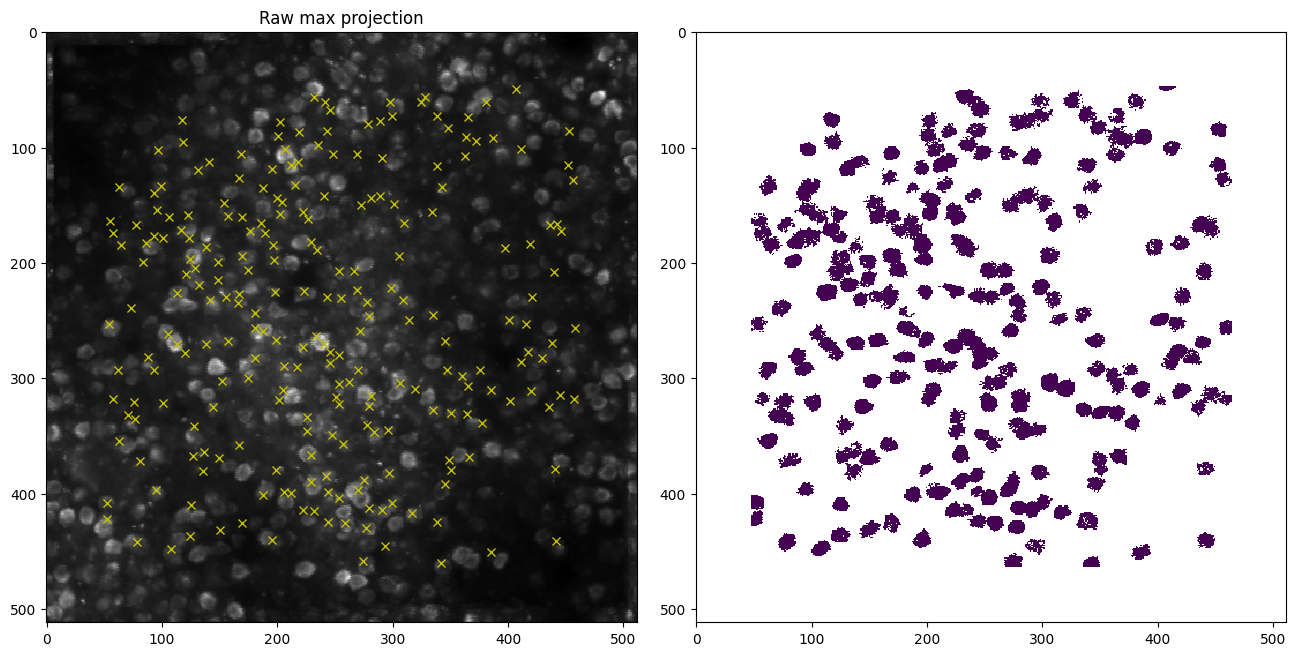

In [87]:
mask = np.zeros((6,512,512))*np.nan
for p in range(6):
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(p+1)

    fig, axes = plt.subplots(1,2,figsize=(16,8),gridspec_kw={'wspace':0.1,'hspace':0.1})
    ax = axes[0]
    ax.set_title(f'Raw max projection')
    ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')

    for stat in data[p]['stat']:
        yc = np.mean(stat['ypix'])
        xc = np.mean(stat['xpix'])

        mask[p,stat['ypix'],stat['xpix']] = 1
        ax.plot(xc,yc,'xy')

    
    


    ax = axes[1]
    ax.imshow(mask[p], cmap='viridis', interpolation='nearest')

Text(0.5, 0, 'Time (s)')

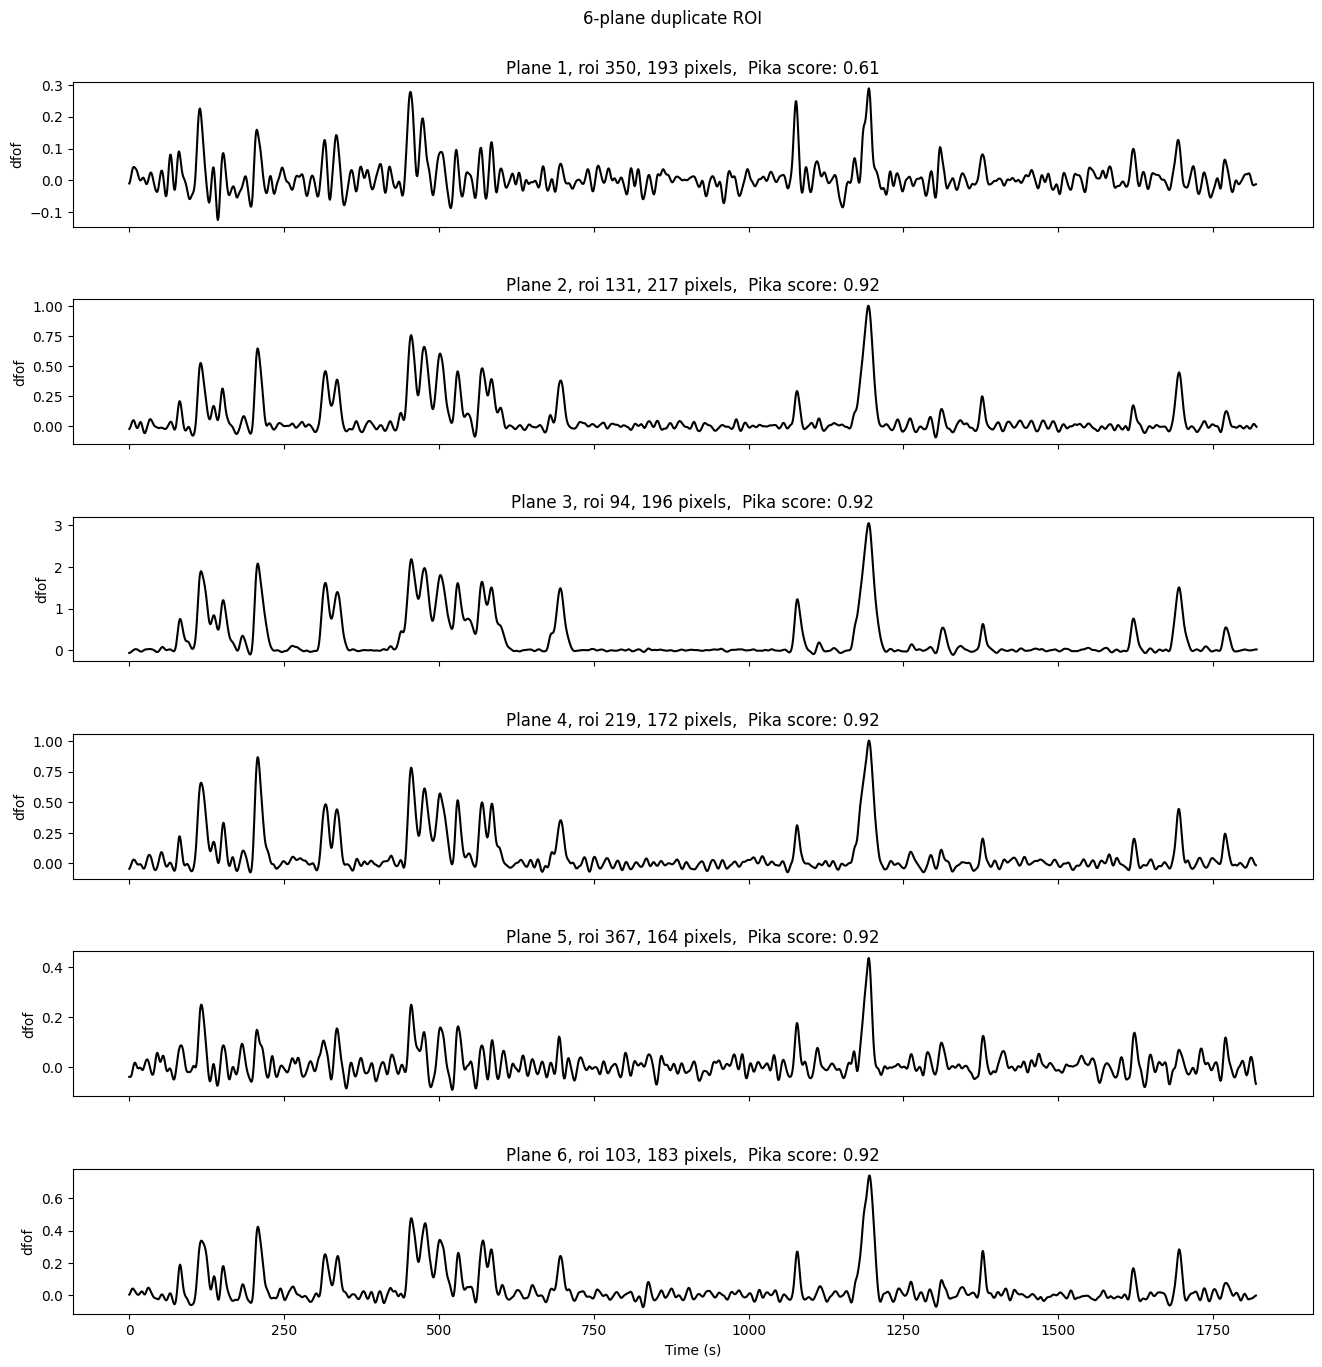

In [32]:
#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
tStart = stim_table.loc[0,'start']
tEnd = stim_table.loc[0,'end']

from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(6,1,figsize=(16,16),gridspec_kw={'hspace':0.5},sharey=False,sharex=True)
plt.suptitle('6-plane duplicate ROI',y=0.925)
trace_list = []
trace_list2 = []
for iPlane, roi_id in enumerate(dupli):
    # data_xr = data_list_interp[iPlane]

    data_xr = sess.get_traces(iPlane+1,'raw')
    str_split = roi_id.split('_')
    roi = int(str_split[-1])
    plane = int(str_split[-2])
    mask = sess.get_roi_image_mask(plane,roi)
    pika_score = sess.get_pika_roi_confidence(plane, roi)

    trace = sess.get_spont_traces(plane,'dff').sel(roi=roi)
    trace2 = data_xr.sel(roi=roi,time=slice(tStart, tEnd))
    trace_list.append(gaussian_filter1d(trace,sigma=3))
    trace_list2.append(gaussian_filter1d(trace2,sigma=3))
    ax = axes[iPlane]
    ax.plot(gaussian_filter1d(trace,sigma=3),'-k')
    ax.set_ylabel('dfof')
    ax.set_title(f'Plane {plane}, roi {roi}, {np.sum(mask)} pixels,  Pika score: {pika_score:.2f}')

    # ax2 = ax.twinx()
    # ax2.plot(gaussian_filter1d(trace2,sigma=3),'-r')
    # ax2.set_ylabel('raw')

ax.set_xlabel('Time (s)')

In [9]:
from allen_v1dd.stimulus_analysis import analysis_tools as at
metrics = at.load_roi_metrics('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics.csv',remove_duplicates=False)
metrics.head()

mouse  column volume  plane  roi  is_valid  \
M409828_11_1_89  409828       1      1      1   89      True   
M409828_11_2_0   409828       1      1      2    0      True   
M409828_11_2_1   409828       1      1      2    1      True   
M409828_11_2_2   409828       1      1      2    2      True   
M409828_11_2_4   409828       1      1      2    4      True   

                 is_ignored_duplicate  has_duplicate  n_duplicates  \
M409828_11_1_89                 False          False             0   
M409828_11_2_0                  False           True             2   
M409828_11_2_1                  False           True             2   
M409828_11_2_2                  False          False             0   
M409828_11_2_4                  False          False             0   

                                 duplicate_rois  ...  spontaneous_event_mean  \
M409828_11_1_89                             NaN  ...                0.000287   
M409828_11_2_0   M409828_11_2_0, M409828_11_3_2  ...                0.000346   
M409828_11_2_1   M409828_11_2_1, M409828_11_3_0  ...                0.000341   
M409828_11_2_2                              NaN  ...                0.000341   
M409828_11_2_4                              NaN  ...                0.000234   

                 spontaneous_event_std  depth_chunk  depth_trunc  vol_plane  \
M409828_11_1_89               0.001903            0            0        1-1   
M409828_11_2_0                0.002629            0            0        1-2   
M409828_11_2_1                0.002262            0            0        1-2   
M409828_11_2_2                0.002412            0            0        1-2   
M409828_11_2_4                0.001601            0            0        1-2   

                 dgw_is_responsive  dgf_is_responsive   ssi_fit  \
M409828_11_1_89              False              False -0.043955   
M409828_11_2_0               False              False -0.073683   
M409828_11_2_1                True               True -0.011145   
M409828_11_2_2                True               True  0.278888   
M409828_11_2_4               False              False -0.100974   

                 dgw_pref_dir_fit  dgf_pref_dir_fit  
M409828_11_1_89         30.681108         69.313722  
M409828_11_2_0          61.781378         43.508462  
M409828_11_2_1          20.539986         13.115250  
M409828_11_2_2         360.000000         66.145993  
M409828_11_2_4         348.754021        307.709808  

[5 rows x 108 columns]

In [21]:
for col in metrics.columns:
    print(col)

mouse
column
volume
plane
roi
is_valid
is_ignored_duplicate
has_duplicate
n_duplicates
duplicate_rois
depth
dgf_pref_response
dgf_pref_dir
dgf_pref_sf
dgf_pref_dir_idx
dgf_pref_sf_idx
dgf_pref_dir_mean
dgf_z_score
dgf_response_p
dgf_osi
dgf_gosi
dgf_dsi
dgf_frac_responsive_trials
dgf_lifetime_sparseness
dgf_p_trial_responses
dgf_sig_trial_responses
dgf_vonmises_0_param_0
dgf_vonmises_0_param_1
dgf_vonmises_0_param_2
dgf_vonmises_0_param_3
dgf_vonmises_0_param_4
dgf_vonmises_0_param_5
dgf_vonmises_0_pref_dir
dgf_vonmises_0_peak_amp
dgf_vonmises_0_r2_score
dgf_vonmises_1_param_0
dgf_vonmises_1_param_1
dgf_vonmises_1_param_2
dgf_vonmises_1_param_3
dgf_vonmises_1_param_4
dgf_vonmises_1_param_5
dgf_vonmises_1_pref_dir
dgf_vonmises_1_peak_amp
dgf_vonmises_1_r2_score
dgf_norm_dir_responses
dgf_pref_ori
dgf_chisq_response_p
dgf_null_dist_multi_mean
dgf_null_dist_multi_std
dgf_null_dist_single_mean
dgf_null_dist_single_std
dgw_pref_response
dgw_pref_dir
dgw_pref_sf
dgw_pref_dir_idx
dgw_pref_sf_

In [15]:
n_planes = []
for ii,row in tqdm(metrics.iterrows()):
    if np.isnan(row.duplicate_rois):
        continue
    n_planes.append(len(row.duplicate_rois))

0it [00:00, ?it/s]

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [50]:
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link
import caveclient
#Find the corresponding em nucleus location
cave_client = caveclient.CAVEclient('v1dd')

# you can use it to just visualize a single neuron
url=make_neuron_neuroglancer_link(cave_client, 864691132826115475, return_as='html')
url

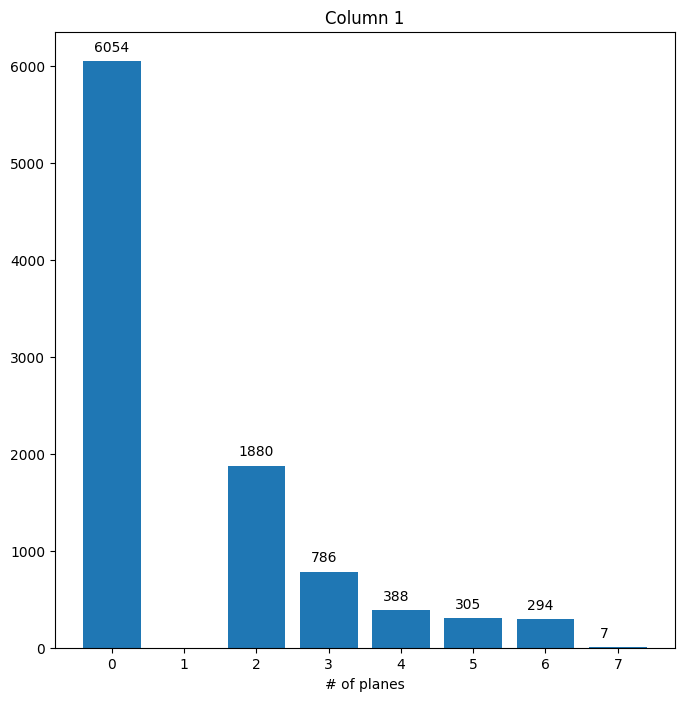

In [48]:
tmp = np.unique(metrics['n_duplicates'].values,return_counts=True)

plt.figure(figsize=(8,8))
plt.title('Column 1')
plt.bar(tmp[0],tmp[1])
plt.xlabel('# of planes')

for ii,t in zip(*tmp):
    plt.text(ii-0.25,t+100,t)